In [1]:
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup

import requests
import csv
import re
import time
from tqdm import tqdm

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import imdb

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)

In [2]:
movie_night_list = [
    'Cats',
#     'Emo the Musical',
#     'Sunday School Musical',
    'Paul Blart Mall Cop 2',
    'Waterworld',
    'Battlefield Earth',
#     'Striking Distance',
    'Twilight',
    'Twilight: New Moon',
    'The Lizzie McGuire Movie',
    'Gigli',
    'Anon',
    'Step Sisters',
    'Rip Tide',
    'Starship Troopers',
    'The Clique',
    'The Last Airbender',
    'Sleepover',
    'The Adventures of Sharkboy and Lavagirl 3-D',
    'The Roommate',
    'Mortal Kombat: The Movie',
    'Ghost Rider',
    'Sex and The City 2',
#     'The Adventures of Pluto Nash',
    'Scooby-Doo',
    'Silent Hill',
    'Resident Evil',
#     'Yinz',
#     'The Anomaly',
#     'Birdemic: Shock and Terror',
    'Super Mario Bros.',
    'Trolls World Tour',
    'Rocky Horror',
    'Street Fighter',
    'A Very Country Christmas',
    'Santa Girl',
    'We Can Be Heroes',
    'Spice World',
    'Star Trek IV',
    'I Know Who Killed Me',
    'Jungle 2 Jungle',
    'Howard the Duck',
    'She’s All That',
    'Hackers',
    'Batman & Robin',
#     'My Brother the Pig',
    'Catwoman'
]

test_movie_list = ['Cats']

In [3]:
def movie_search(movie_title, base_url):
    search_query = base_url + movie_title
    response = requests.get(search_query)
    return response

In [4]:
search_base_url = 'https://www.commonsensemedia.org/search/'
review_base_url = 'https://www.commonsensemedia.org'
movie_search_list = [re.sub(' ', '%20', x) for x in movie_night_list]

In [5]:
review_url_list = []

for movie_title in movie_search_list:
    response = movie_search(movie_title, search_base_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    div_list = soup.find_all('div', {'class':'result-title'})

    for div_item in div_list:
        child_item = div_item.findChildren('a')
        if len(child_item) > 0:
            review_url_list.append(child_item[0]['href'])
            break

In [6]:
child_reviews = [review_base_url + review_url + '/user-reviews/child' for review_url in review_url_list]
adult_reviews = [review_base_url + review_url + '/user-reviews/adult' for review_url in review_url_list]

In [7]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

In [11]:
installed_chrome_driver = ChromeDriverManager().install()

def scrape_urls(target_url):
    options = webdriver.ChromeOptions()
    options.add_argument('headless')
    
    driver = webdriver.Chrome(installed_chrome_driver, chrome_options=options)
    driver.get(target_url)
    review_buttons = driver.find_elements_by_class_name('read-more-close')

    for x in range(len(review_buttons)):
        if review_buttons[x].is_displayed():
            driver.execute_script("arguments[0].click();", review_buttons[x])
            time.sleep(1)

    page_source = driver.page_source

    soup = BeautifulSoup(page_source, 'html.parser')

    # get review data

    user_one_liners = [x.text for x in soup.find_all('span', {'class':'user-one-liner'})]
    review_created_dates = [x.text for x in soup.find_all('span', {'class':'views-field-created'})]

    age_recommendations = [x.text for x in soup.find_all('div', {'class':'csm-green-age'})]
    csm_age_rec = [age_recommendations[0]]

    star_ratings = soup.find_all('div', {'class':'star'})
    csm_rating = [star_ratings[0]['class'][2]]

    reviews = soup.find_all('div', {'class':'user-review-content'})

    review_titles = [review.findChildren('h4', {'class':'user-review-title'}) for review in reviews]
    review_titles = [x[0].text if len(x) > 0 else '' for x in review_titles]

    review_text = [review.findChildren('div', {'class':'user-review-text'}) for review in reviews]
    review_text = [x[0].text if len(x) > 0 else '' for x in review_text]

    grid_items = [review.findChildren('div', {'class':'field-content-grid-type'}) for review in reviews]
    grid_items = ['' if len(x) == 0 else [x[j]['title'] for j in range(len(x))] for x in grid_items]

    age_recommendations = [review.findChildren('div', {'class':'csm-green-age'}) for review in reviews]
    age_recommendations = [x[0].text if len(x) > 0 else '' for x in age_recommendations]

    star_rating_list = [review.findChildren('div', {'class':'star'}) for review in reviews]
    star_rating_list = [x[0]['class'][2] if len(x) > 0 else '' for x in star_rating_list]
    
    next_pagers = soup.find_all('li', {'class':'pager-next'})

    if len(next_pagers) > 0:
        next_page_url = next_pagers[0].findChildren('a')[0]['href']
        scrape_results = scrape_urls(review_base_url + next_page_url)

        user_one_liners += scrape_results[0]
        review_created_dates += scrape_results[1]
        review_titles += scrape_results[4]  
        review_text += scrape_results[5]
        grid_items += scrape_results[6]
        age_recommendations += scrape_results[7]
        star_rating_list += scrape_results[8]
        
    
    return user_one_liners, review_created_dates, csm_age_rec, csm_rating, review_titles, review_text, grid_items, age_recommendations, star_rating_list

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 89.0.4389
[WDM] - Get LATEST driver version for 89.0.4389
[WDM] - Driver [/Users/scottduda/.wdm/drivers/chromedriver/mac64/89.0.4389.23/chromedriver] found in cache


In [12]:
def scrape_reviews(review_url_list):
    # driver = webdriver.Chrome('/usr/local/bin/chromedriver')
    # page_url = 'https://www.commonsensemedia.org/movie-reviews/catwoman/user-reviews/adult'

    one_liners = []
    review_dates = []
    csm_age_recs = []
    csm_stars = []
    rev_titles = []
    rev_text = []
    grid_cats = []
    age_recs = []
    star_list = []

    for page_url in tqdm(review_url_list):

        page_scrape_results = scrape_urls(page_url)
        
        one_liners.append(page_scrape_results[0])
        review_dates.append(page_scrape_results[1])
        csm_age_recs.append(page_scrape_results[2])
        csm_stars.append(page_scrape_results[3])
        rev_titles.append(page_scrape_results[4])
        rev_text.append(page_scrape_results[5])
        grid_cats.append(page_scrape_results[6])
        age_recs.append(page_scrape_results[7])
        star_list.append(page_scrape_results[8])
        
        
    df = pd.DataFrame(list(zip(movie_night_list, one_liners, review_dates, csm_age_recs, age_recs, rev_titles, rev_text, grid_cats, csm_stars, star_list)),
                      columns = ['movie_title', 'one_liners', 'review_dates', 'csm_age_recs', 'age_recs', 'rev_titles', 'rev_text', 'grid_cats', 'csm_stars', 'star_list'])

    return df

In [13]:
adult_df = scrape_reviews(adult_reviews)
child_df = scrape_reviews(child_reviews)

100%|██████████| 39/39 [23:06<00:00, 35.55s/it]  


In [14]:
child_df.head()

,movie_title,one_liners,review_dates,csm_age_recs,age_recs,rev_titles,rev_text,grid_cats,csm_stars,star_list
0,Cats,"[Kid, 12 years old, Teen, 13 years old, Teen, ...","[December 19, 2019, December 28, 2019, January...",[age 10+],"[age 18+, age 11+, age 8+, age 9+, age 18+, ag...","[Don't even bother., Cats: Get Ready To Waste...",[I can't believe some idiots gave this movie 4...,"[[Violence & scariness], [Sexy stuff], [Sexy s...",[rating-3],"[rating-1, rating-1, rating-1, rating-5, ratin..."
1,Paul Blart Mall Cop 2,"[Teen, 14 years old, Teen, 14 years old, Teen,...","[April 25, 2015, April 20, 2015, May 17, 2016,...",[age 11+],"[age 7+, age 9+, age 13+, age 9+, age 9+, age ...","[Paul Blart Mall Cop 2 , Better than #1, Stupi...",[It is not worth seeing in the movies. When i ...,"[[Drinking, Drugs & Smoking], , , [Positive ro...",[rating-2],"[rating-2, rating-4, rating-1, rating-4, ratin..."
2,Waterworld,"[Teen, 15 years old, Teen, 14 years old, Teen,...","[June 8, 2012, December 3, 2011, February 15, ...",[age 13+],"[age 14+, age 12+, age 15+, age 9+, age 9+]","[Not that amazing but not terrible, Skip., , t...",[If I was to rate this movie it would be:\nPG-...,"[[Violence & scariness, Sexy stuff, Language],...",[rating-3],"[rating-2, rating-2, rating-4, rating-1, ratin..."
3,Battlefield Earth,"[Kid, 11 years old, Teen, 16 years old, Teen, ...","[February 12, 2021, April 12, 2018, July 3, 20...",[age 13+],"[age 6+, age 10+, age 12+, age 14+, age 7+, ag...",[Only Reason It Is 3 Star Is Because It Is Fun...,[The only reason this is a 3 star is it is so ...,"[[Violence & scariness, Sexy stuff], [Language...",[rating-1],"[rating-3, rating-2, rating-1, rating-1, ratin..."
4,Twilight,"[Teen, 14 years old, Teen, 13 years old, Teen,...","[May 14, 2015, September 16, 2013, March 31, 2...",[age 13+],"[age 12+, age 18+, age 12+, age 11+, age 11+, ...","[The worst movie I have ever watched, WORST. M...",[This movie is absolutely crap. The acting is ...,"[, [Violence & scariness, Sexy stuff, Language...",[rating-3],"[rating-1, rating-1, rating-3, rating-5, ratin..."


In [15]:
child_df.shape

(39, 10)

In [16]:
adult_df.head()

,movie_title,one_liners,review_dates,csm_age_recs,age_recs,rev_titles,rev_text,grid_cats,csm_stars,star_list
0,Cats,"[Adult, Adult, Adult, Adult, Adult, Adult, Adu...","[January 3, 2020, January 4, 2020, December 27...",[age 10+],"[age 17+, age 3+, age 4+, age 18+, age 10+, ag...","[Horrifying, Follow your instinct, Magical Mus...",[Watch this if you’re bored with the way your ...,"[[Sexy stuff], [Positive Messages, Positive ro...",[rating-3],"[rating-1, rating-5, rating-5, rating-1, ratin..."
1,Paul Blart Mall Cop 2,"[Adult, Adult, Adult, Parent of a 10, 12, and...","[April 24, 2015, April 5, 2019, January 1, 201...",[age 11+],"[age 2+, age 13+, age 5+, age 11+, age 17+]","[Why are you not at the movie now?, Paul blart...",[There are a lot of funny moments where you wi...,"[, [Violence & scariness, Sexy stuff, Drinking...",[rating-2],"[rating-5, rating-5, rating-4, rating-4, ratin..."
2,Waterworld,"[Parent of a 15-year-old, Parent of a 2-year-old]","[May 1, 2020, November 7, 2012]",[age 13+],"[age 14+, age 13+]",[Don't listen to the bad reputation. It's actu...,"[Waterworld is an amazingly entertaining film,...","[, [Positive Messages, Positive role models, V...",[rating-3],"[rating-4, rating-3]"
3,Battlefield Earth,"[Adult, Adult, Adult]","[April 11, 2010, April 9, 2008, April 9, 2008]",[age 13+],"[age 14+, age 17+, not rated for age]",[There is only one thing preventing this from ...,[And that's the simple fact that it's so bad i...,"[[Violence & scariness, Sexy stuff, Language, ...",[rating-1],"[rating-2, rating-2, rating-1]"
4,Twilight,"[Adult, Parent of a 2 and 4-year-old, Adult, A...","[September 14, 2010, September 18, 2010, July ...",[age 13+],"[age 13+, age 10+, age 13+, age 17+, age 12+, ...","[Tell your kids to read the books first!!, Why...","[I gave it 2 stars for how bad this movie is, ...","[[Sexy stuff, Positive Messages, Positive role...",[rating-3],"[rating-2, rating-1, rating-5, rating-1, ratin..."


In [17]:
adult_df.shape

(39, 10)

In [18]:
def flatten_df(df):
    new_df_list = []
    for i in range(len(df)):
        movie_series = df.iloc[i, :]
        movie_title = movie_series['movie_title']
        csm_age_rec = movie_series['csm_age_recs'][0]
        csm_star = movie_series['csm_stars'][0]
        
        
        for j in range(len(movie_series['one_liners'])):
            new_row = [movie_title]
            new_row.append(movie_series['one_liners'][j])
            new_row.append(movie_series['review_dates'][j])
            new_row.append(csm_age_rec) # FIX - FORMAT TO INT BASED ON VALUE_COUNTS
            new_row.append(movie_series['age_recs'][j]) # FIX - FORMAT TO INT BASED ON VALUE_COUNTS
            new_row.append(movie_series['rev_titles'][j])
            new_row.append(movie_series['rev_text'][j])
            new_row.append(movie_series['grid_cats'][j])
            new_row.append(csm_star) # FIX - FORMAT TO INT BASED ON VALUE_COUNTS
            new_row.append(movie_series['star_list'][j])
            
            new_df_list.append(new_row)

           
    return pd.DataFrame(new_df_list, columns=df.columns)

In [19]:
child_review_df = flatten_df(child_df)
adult_review_df = flatten_df(adult_df)

In [20]:
def clean_reviewer_age(rev_age):
    rev_age = re.sub('[^0-9]', '', rev_age)
    if rev_age == '':
        return 'Unk'
    else:
        return int(rev_age.strip())

def clean_age_recs(age_rec):
    if age_rec != 'not rated for age':
        return re.sub('[^0-9]', '', age_rec).strip()
    else:
        return str(age_rec).strip()

In [21]:
def clean_df(df):
    df['reveiwer_classification'] = df['one_liners'].apply(lambda x: str(x.split(',')[0]))
    df['reviewer_age'] = df['one_liners'].apply(lambda x: clean_reviewer_age(x))
    df.loc[df['reviewer_age'] == '', 'reviewer_age'] = 'Unk'
    df['review_dates'] = pd.to_datetime(df['review_dates'])
    df['csm_min_age'] = df['csm_age_recs'].apply(lambda x: int(re.sub('[^0-9]', '', x).strip()))
    df['reviewer_min_age'] = df['age_recs'].apply(clean_age_recs)
    df['csm_stars'] = df['csm_stars'].apply(lambda x: int(re.sub('[^0-9]', '', x).strip()))
    df['reviewer_stars'] = df['star_list'].apply(lambda x: int(re.sub('[^0-9]', '', x).strip()))
    df['reviewer_min_age'] = df['age_recs'].apply(clean_age_recs)
    
    return df.drop(['one_liners', 'csm_age_recs', 'age_recs', 'star_list'], axis=1)
    

In [22]:
child_review_df = clean_df(child_review_df)
adult_review_df = clean_df(adult_review_df)

In [23]:
child_review_df.head()

,movie_title,review_dates,rev_titles,rev_text,grid_cats,csm_stars,reveiwer_classification,reviewer_age,csm_min_age,reviewer_min_age,reviewer_stars
0,Cats,2019-12-19,Don't even bother.,I can't believe some idiots gave this movie 4/...,[Violence & scariness],3,Kid,12,10,18,1
1,Cats,2019-12-28,Cats: Get Ready To Waste Your Time,"This is the most horrible, God-forsaken movie...",[Sexy stuff],3,Teen,13,10,11,1
2,Cats,2020-01-03,"Not for Dog People, but seriously...ITS BAD",I was disappointed at the lack of Dogs in the ...,[Sexy stuff],3,Teen,17,10,8,1
3,Cats,2019-12-20,,,,3,Teen,14,10,9,5
4,Cats,2019-12-28,this movie literally gives me nightmares,hello! you might think to take ur child to thi...,[Violence & scariness],3,Teen,15,10,18,1


In [24]:
adult_review_df.head()

,movie_title,review_dates,rev_titles,rev_text,grid_cats,csm_stars,reveiwer_classification,reviewer_age,csm_min_age,reviewer_min_age,reviewer_stars
0,Cats,2020-01-03,Horrifying,Watch this if you’re bored with the way your m...,[Sexy stuff],3,Adult,Unk,10,17,1
1,Cats,2020-01-04,Follow your instinct,It was great! Honestly. How was it not going t...,"[Positive Messages, Positive role models]",3,Adult,Unk,10,3,5
2,Cats,2019-12-27,Magical Musical,I saw it last weekend with my 4.5 year old. I ...,"[Positive Messages, Sexy stuff]",3,Adult,Unk,10,4,5
3,Cats,2019-12-26,THE WORST,this movie was terrible. 10/10 would not recom...,"[Violence & scariness, Sexy stuff, Language, D...",3,Adult,Unk,10,18,1
4,Cats,2019-12-24,Better than critics say,I had heard critic reviews that panned the mov...,[Positive Messages],3,Adult,Unk,10,10,4


In [93]:
adult_review_df['rev_text'].isna().sum()

0

In [95]:
adult_review_df['rev_text'].values[12]

''

In [92]:
child_review_df.to_csv('data/csm_child_reviews.csv')
adult_review_df.to_csv('data/csm_adult_reviews.csv')

In [31]:
mean_child_ratings = child_review_df.groupby('movie_title').agg(np.mean)
mean_adult_ratings = adult_review_df.groupby('movie_title').agg(np.mean)

In [52]:
child_rating_counts = child_review_df.groupby('movie_title').agg('count')
adult_rating_counts = adult_review_df.groupby('movie_title').agg('count')

In [55]:
rating_df = pd.DataFrame(list(zip(mean_child_ratings.index.values, mean_child_ratings['csm_stars'].values, mean_child_ratings['reviewer_stars'].values, mean_adult_ratings['reviewer_stars'].values, child_rating_counts['review_dates'], adult_rating_counts['review_dates'])), 
                         columns=['movie_title', 'csm_rating', 'mean_child_rating', 'mean_adult_rating', 'num_child_reviews', 'num_adult_reviews'])

In [62]:
child_filtered_rating_df = rating_df.loc[rating_df['num_child_reviews'] >= 5]
adult_filtered_rating_df = rating_df.loc[rating_df['num_adult_reviews'] >= 5]

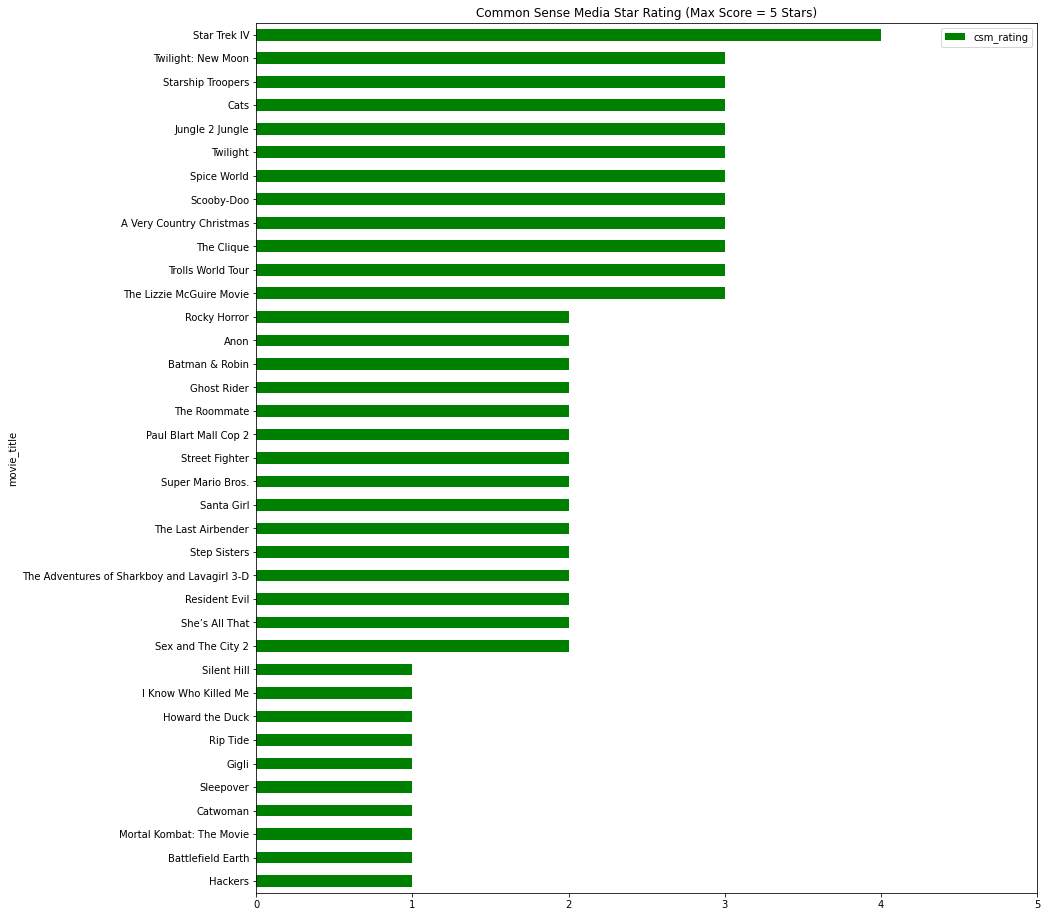

In [107]:
rating_df.sort_values(by='csm_rating').plot(x='movie_title', y=['csm_rating'], kind='barh', figsize=(14,16), color='green')
plt.title('Common Sense Media Star Rating (Max Score = 5 Stars)')
plt.xlim([0,5])
plt.savefig('images/csm_ratings.png')
plt.show()

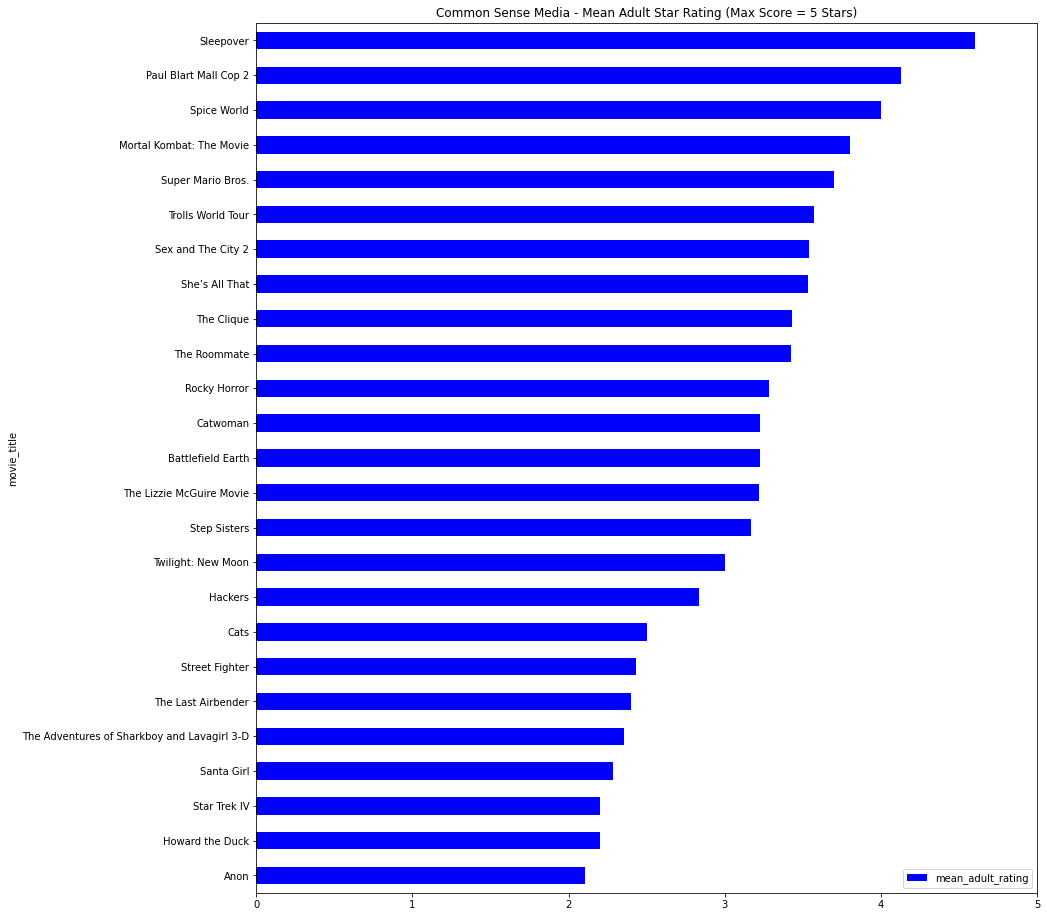

In [108]:
adult_filtered_rating_df.sort_values(by='mean_adult_rating').plot(x='movie_title', y=['mean_adult_rating'], kind='barh', figsize=(14,16), color='blue')
plt.title('Common Sense Media - Mean Adult Star Rating (Max Score = 5 Stars)')
plt.xlim([0,5])
plt.savefig('images/csm_adult_ratings.png')
plt.show()

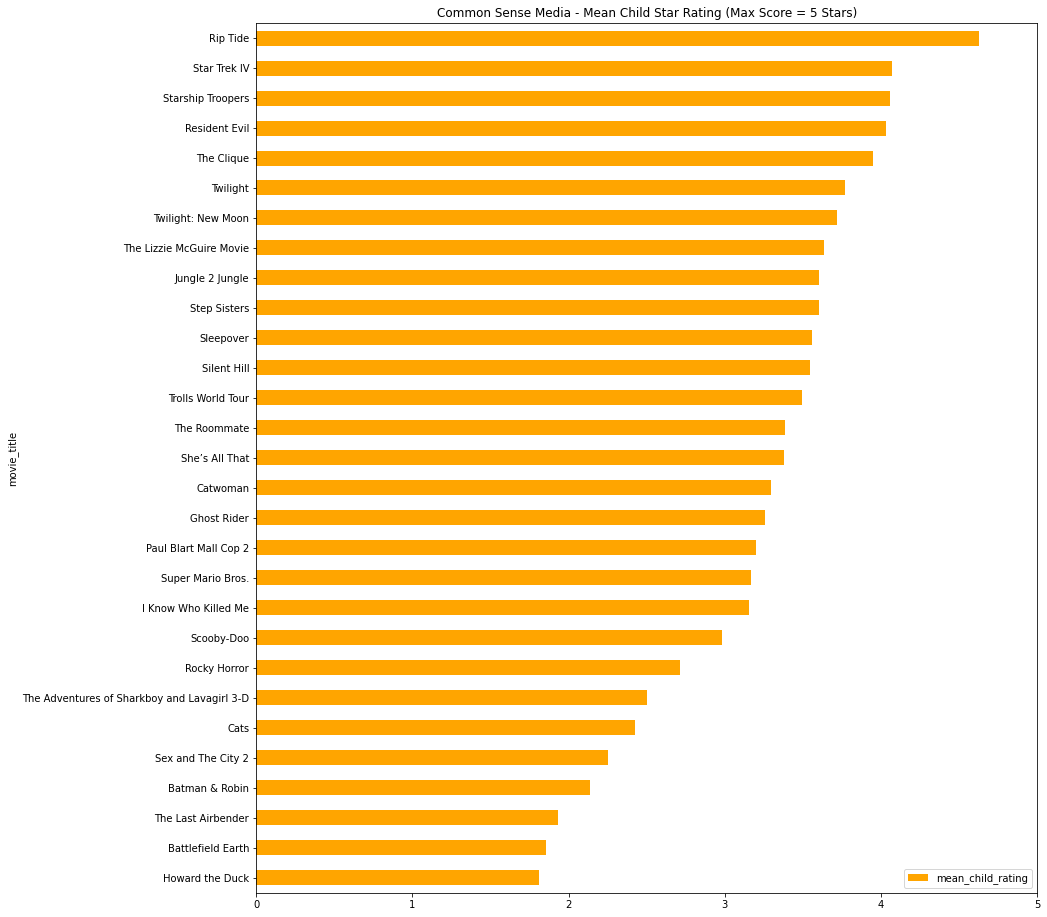

In [109]:
child_filtered_rating_df.sort_values(by='mean_child_rating').plot(x='movie_title', y=['mean_child_rating'], kind='barh', figsize=(14,16), color='orange')
plt.title('Common Sense Media - Mean Child Star Rating (Max Score = 5 Stars)')
plt.xlim([0,5])
plt.savefig('images/csm_child_ratings.png')
plt.show()

In [65]:
adult_filtered_rating_df['csm_adult_dif'] = adult_filtered_rating_df['csm_rating'] - adult_filtered_rating_df['mean_adult_rating'] 
child_filtered_rating_df['csm_child_dif'] = child_filtered_rating_df['csm_rating'] - child_filtered_rating_df['mean_child_rating'] 

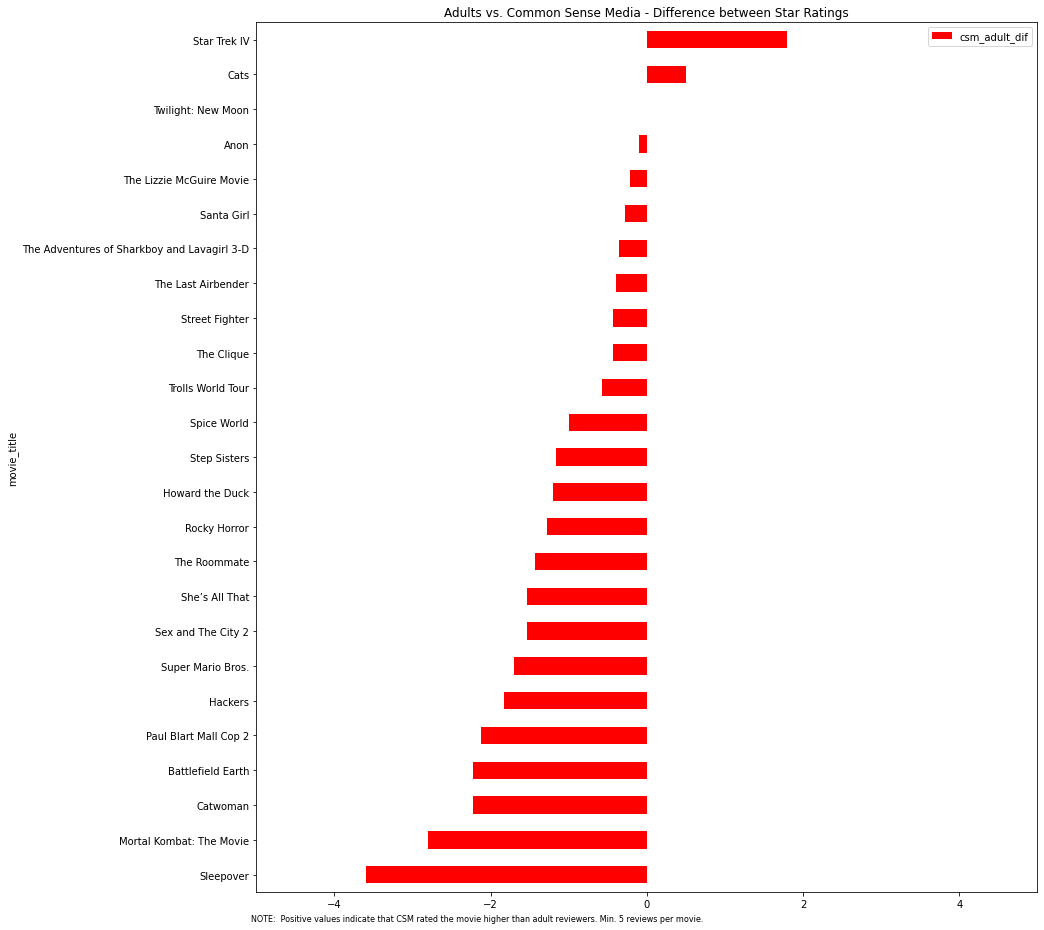

In [110]:
adult_filtered_rating_df.sort_values(by='csm_adult_dif').plot(x='movie_title', y=['csm_adult_dif'], kind='barh', figsize=(14,16), color='red')
plt.title('Adults vs. Common Sense Media - Difference between Star Ratings')
plt.figtext(0.12, 0.1, 'NOTE:  Positive values indicate that CSM rated the movie higher than adult reviewers. Min. 5 reviews per movie.', fontsize=8)
plt.xlim([-5,5])
plt.savefig('images/adults_v_csm.png')
plt.show()

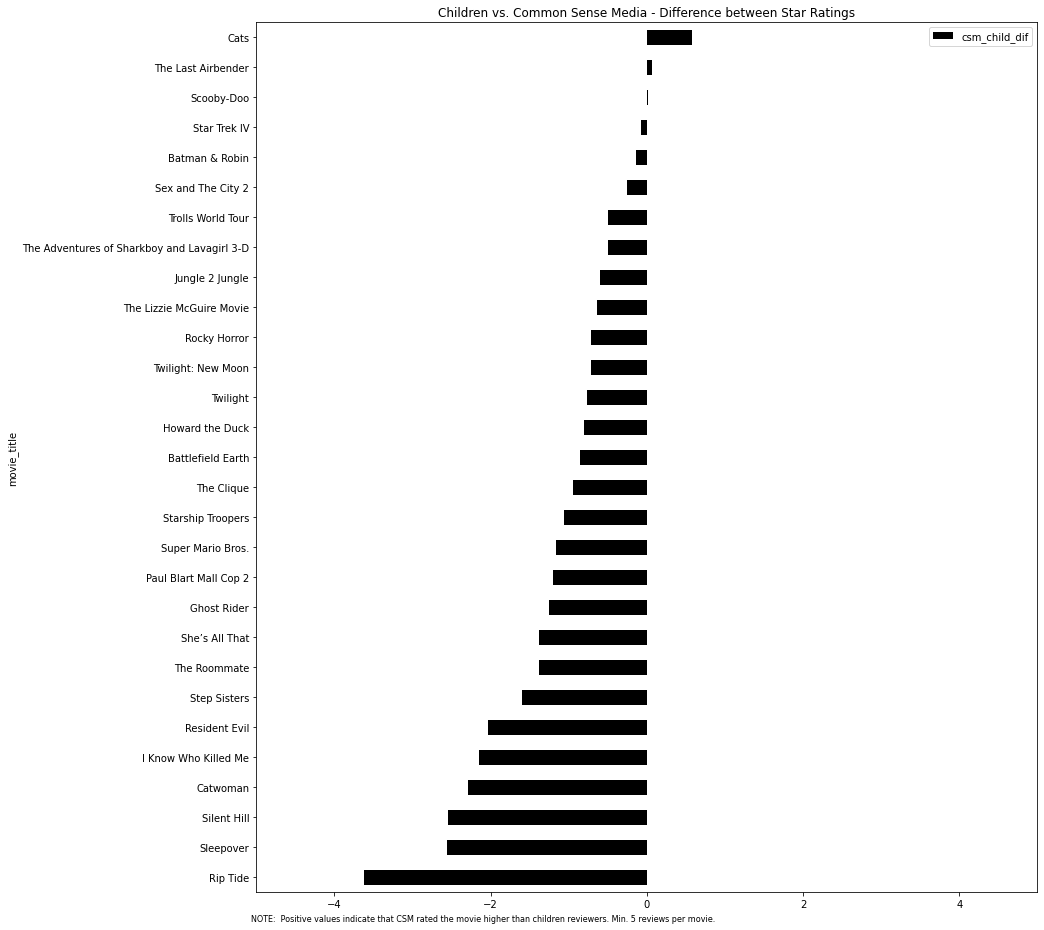

In [111]:
child_filtered_rating_df.sort_values(by='csm_child_dif').plot(x='movie_title', y=['csm_child_dif'], kind='barh', figsize=(14,16), color='black')
plt.title('Children vs. Common Sense Media - Difference between Star Ratings')
plt.figtext(0.12, 0.1, 'NOTE:  Positive values indicate that CSM rated the movie higher than children reviewers. Min. 5 reviews per movie.', fontsize=8)
plt.xlim([-5,5])
plt.savefig('images/child_v_csm.png')
plt.show()

In [73]:
grid_cats = list(child_review_df['grid_cats'].values) + list(adult_review_df['grid_cats'].values)

In [76]:
grid_cats = [x for x in grid_cats if x != '']

In [78]:
grid_cats = [item for sublist in grid_cats for item in sublist]

In [81]:
pd.Series(grid_cats).value_counts()

Violence & scariness         723
Sexy stuff                   638
Positive Messages            536
Positive role models         525
Language                     357
Consumerism                  263
Drinking, Drugs & Smoking    225
Educational Value              5
dtype: int64

In [82]:
rating_df

,movie_title,csm_rating,mean_child_rating,mean_adult_rating,num_child_reviews,num_adult_reviews,csm_adult_dif,csm_child_dif
0,A Very Country Christmas,3.0,1.000000,1.000000,1,3,2.000000,2.000000
1,Anon,2.0,1.500000,2.105263,2,19,-0.105263,0.500000
2,Batman & Robin,2.0,2.138298,1.666667,94,3,0.333333,-0.138298
3,Battlefield Earth,1.0,1.857143,3.223881,7,67,-2.223881,-0.857143
4,Cats,3.0,2.422680,2.500000,97,6,0.500000,0.577320
5,Catwoman,1.0,3.291667,3.225806,24,31,-2.225806,-2.291667
6,Ghost Rider,2.0,3.258621,3.000000,58,3,-1.000000,-1.258621
7,Gigli,1.0,1.000000,4.500000,1,2,-3.500000,0.000000
8,Hackers,1.0,3.000000,2.833333,1,18,-1.833333,-2.000000
9,Howard the Duck,1.0,1.807692,2.200000,26,5,-1.200000,-0.807692


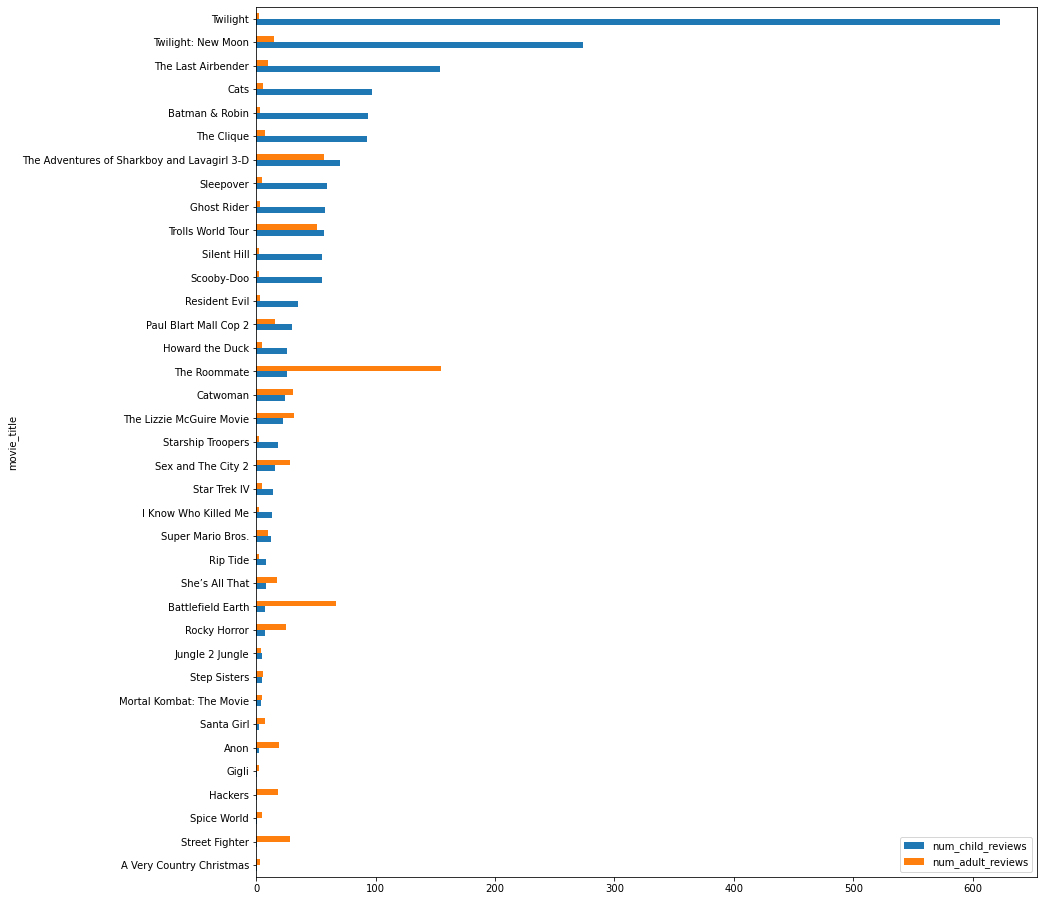

In [112]:
rating_df.sort_values(by='num_child_reviews').plot(x='movie_title', y=['num_child_reviews', 'num_adult_reviews'], kind='barh', figsize=(14,16))
plt.savefig('images/rev_counts.png')
plt.show()

In [97]:
adult_review_df['rev_length'] = adult_review_df['rev_text'].apply(lambda x: len(x.split(' ')))
child_review_df['rev_length'] = child_review_df['rev_text'].apply(lambda x: len(x.split(' ')))